# Social Computing/Social Gaming - Summer 2020

# Exercise Sheet 5 : K-Means and EVE

In this exercise, we will revisit the K-means clustering algorithm from the lecture and apply it to data gathered from the sandbox MMO *EVE Online*. We will explore whether we can find indications for Radoff's player types when applying the algorithm with k=4. As a refresher, Radoff's model posits that players can be divided into 4 groups: Socializers, achievers, explorers and killers.

For those of you unfamiliar with EVE, here is a brief explanation that should help in working with the data: In Eve, a player takes control over a clone in a fictional galaxy with a fully-functioning, player-driven economy. There are no set roles, but players usually form alliances and choose roles based on what they like to do most. Much of the game revolves around spaceship combat, but many players concentrate on mining and processing resources which are needed to build ships and stations. Other players enjoy a more lone-wolf style of game and either explore the galaxy or hunt other players. EVE's most unique feature is the doctrine of no safe spaces: There are zones in which killing is prohibited, but the NPC law enforcement does not work as a prevention unit, only as a force of retaliation. This makes preying on new players much easier than in other games that do have safe havens.

If you want to know more about the game or feel that this explanation was not helpful enough, the Wikipedia article about EVE Online is a good place to start.

Before the actual task starts, try to think of general behavior patterns that would describe EVE players falling into Radoff's categories. What characterizes achievers? How would you distinguish them from killers?

### The Data:

Below, you will find the code used to gather the data, given a number of character IDs from the game. **Important: Do not run this code! It only serves as part of the explanation for the data!** We have commented it out for you. 

For every player, the following information was retrieved:

- `soloRatio`: Measures how many kills the player has achieved without the assistance of others
- `secStatus`: An in-game metric that measures the criminal activity: Killing players in safe zones (without a valid reason) lowers the security status
- `shipsDestroyed`: The number of ships the character has destroyed (alone or with help of others)
- `combatShipsLost`: The amount of ships lost that are classified as combat ships
- `miningShipsLost`: These are ships used for harvesting resources and have limited to no combat capabilities
- `exploShipsLost`: These ships are used to explore the galaxy and only have limited defensive capabilities
- `otherShipsLost`: This category consists of ships that could be considered "support" classes: Freighters (i.e. cargo ships), logistics (i.e. a "healer" in a typical MMO), etc.

Note that losing ships might not always be an indication of what ships players actually use the most (which is what we want to know). It could be possible that some players just never lose a certain type of ship, right? However, given the violent nature of the game and statistics like these (http://evemaps.dotlan.net/stats) it is very unlikely.

Based on this, we will assume the following regarding the types of players:

- Explorers: Low kill/death ratio, high use of exploration ships, rather low kill numbers, high security status
- Socializers: Low kill/death ratio, high security status, low soloRatio, high amount of non-combat ships lost
- Achievers: High kill/death ratio ? (Depends on what you define as "achieving")
- Killers: High kill/death ratio, high soloRatio, low security status, losing virtually only combat ships

In [1]:
# import json
# import urllib
# import pandas as pd
# import re
# import requests
# import html
# import json
# import math


# # Create the dataframe to store everything in:
# columns = ['characterID', 'soloRatio', 'secStatus', 'shipsDestroyed', 'combatShipsLost', 'miningShipsLost', 'exploShipsLost', 'otherShipsLost']
# data = pd.DataFrame()
# character_IDs = pd.read_csv(r'EVEPlayerStats.csv')
# IDList = character_IDs['characterID'].values.tolist()

# IDList = IDList[:500]

# for characterID in IDList:
#     print(characterID)
#     end = False;
#     i =2;
#     combatShips = 0
#     exploShips = 0
#     miningShips = 0
#     otherShips = 0
#     #Get general info: Name, soloratio, secStatus and handle JSON not existing
#     try:
#         link = "https://zkillboard.com/api/stats/characterID/" + str(characterID) + "/"
#         f = requests.get(link)
#         file= json.loads(f.text)
#     except ValueError:
#         print("couldnt decode")
#     if 'gangRatio' not in file:
#         print("next")
#     else:
        
#         soloRatio = 100- file['gangRatio']
#         info = file['info']
#         secStatus = info['secStatus']
#         groups = file['groups']

#         # numbers for groups are already present in the JSON
#         frame = pd.DataFrame.from_dict(groups)
#         shipLosses =pd.DataFrame(frame.iloc[1])
#         for key, value in shipLosses.iterrows():
#             if (key == "25" or key=="29" or key == "31" or key == "1246" or key == "1250" or key == "311" or key == "361" or key == "363" or
#             key == "365" or key == "417" or key == "471" or key == "1025" or key == "1249" or key == "1273" or key == "1276"):
#                 #TODO ignore:
#                 print("ignoring")
#             elif key == "380" or key == "513" or key == "832" or key == "1202" or key == "1527":
#                 if math.isnan(value[0]):
#                     otherShips+=0
#                 else:
#                     otherShips+=int(value[0])
#             elif key == "463" or key == "543" or key == "883" or key == "941" or key == "1283":
#                 if math.isnan(value[0]):
#                     miningShips+=0
#                 else:
#                     miningShips+=int(value[0])
#             elif key == "830":
#                 if math.isnan(value[0]):
#                     exploShips+=0
#                 else:
                    
#                     exploShips+=int(value[0])
#             else:
#                 if math.isnan(value[0]):
#                     combatShips+=0
#                 else:
#                     combatShips+=int(value[0])

#         data = data.append({'characterID': characterID, 'soloRatio': soloRatio, 'secStatus': secStatus, 'shipsDestroyed': 0, 'combatShipsLost': combatShips, 
#                             'miningShipsLost': miningShips, 'exploShipsLost': exploShips, 'otherShipsLost': otherShips}, ignore_index = True)

# if len(data) > 0:
#     data.to_csv(r'C:\Users\jgott\Documents\EVEPlayerStatsNew.csv')

## Task 5.1: Preparation

Now that you are armed with all the knowledge needed, let us begin. First, read the .csv that you downloaded with this exercise into a dataframe and drop the `Unnamed: 0` and `characterID` columns. We don't need them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#TODO:
df = pd.read_csv('EVEPlayerStats.csv', header=0).drop(columns=['Unnamed: 0', 'characterID'])

## Task 5.2: Normalizing & Clustering

As you might have seen, the value ranges differ greatly across the metrics. Where the number of kills can reach up to 10.000, the security status rarely exceeds 5. This creates an imbalance, as the calculation of distance will obviously be impacted a lot more by kill counts than security status. To rectify this and let all metrics influence the result in an equal manner, we need to normalize the data. 

**1.** Go through the dataframe and normalize all values by dividing by the max value for each column.

There is still one problem with the dataset: Even normalized, the clustering 'favors' those players with higher numbers: For example, where we to posit that explorers have a high amount of exploration ships lost, then a player with 200 lost ships would rather be classified as an explorer than a player with 5 lost ships, even if the former lost 2000 non-exploration ships and the latter lost only 2 non-exploration ships. EVE Online has been around since 2003, so there exist players who have played the game extensively for 13 years, while some others might have played for only 2. To mitigate this, we should look at ratios in ship losses: How big is the percentage of lost combat/exploration/mining/other ships given the total amount of ships lost? 

**2.** Convert the absolute numbers into ratios.  


**3.** Cluster the dataset with the k-Means algorithm.

**Hint:** For the clustering we will use the k-means algorithm provided by the scikit-learn library. Import the algorithm and use the `fit()` function to let the algorithm do its work. Remember to set the amount of clusters to 4. 

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# TODO 1: Normalize all values by dividing by the max value for each column.
df = df / df.max()

# TODO 2: Convert the absolute numbers into ratios.
df.iloc[:, :4] = df.iloc[:, :4].div(df.iloc[:, :4].sum(axis=1), axis=0)

# df['totalShipsLost'] = df.iloc[:, :4].sum(axis=1)
# df.iloc[:, :4] = df.iloc[:, :4].div(df['totalShipsLost'], axis=0)
# df = df.drop(columns='totalShipsLost')

# TODO 3: Cluster the dataset with the k-Means algorithm.
kmeans = KMeans(n_clusters=4, random_state=0).fit(df)

## Task 5.3: Analysing the results

### **a)** Heatmap

Since we have 7 features for each player in total, our datapoints lie in a 7-dimensional space. It can be tricky to read a 7-dimensional graph, so we will first use a heatmap to analyze our data. A heatmap is a data visualization technique that shows the data as color in two dimensions.

**1.** Use the seaborn library to generate a heatmap. For readability purposes, display the first 20 players from the dataset **only**.  
**Hint:** If you feel like the graph is too small, scale it up a bit.

**2.** From these 20 entries, choose 4 that you think are the most representative for each of Radoff's player groups and briefly explain why you chose them based on the heatmap.

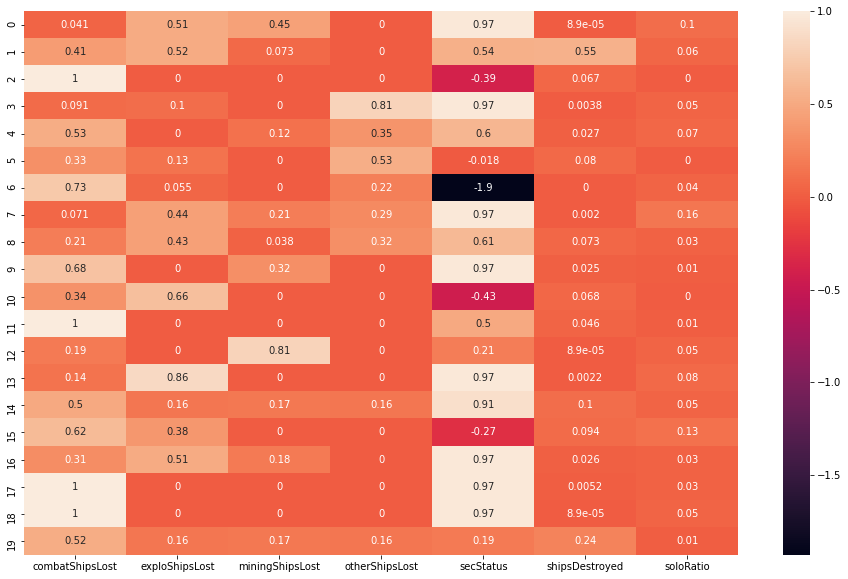

In [4]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# TODO 1:
plt.figure(figsize=(16,10))
sns.heatmap(df.iloc[:20], annot=True)
plt.show()

**TODO 2: Write your observations here:**

- **Player 13 could be an Explorer**, since almost all of his lost ships are exploration ships. He also has low kill numbers and high security status, which indicates he probably only use the limited defensive capabilities of exploration ships for defending during the explorations.
- **Player 3 could be a Socializer**, because he mostly lost ships of other type, which should be supporting ships (e.g. carriers, healers) and trading ships (e.g. freighters). These types of ships are supposed to be used in contexts of freindly relationships with other players, e.g. using supporting ships to support friends in battles or using trading ship to trade with friends etc. In addition, this player also has low ratio of combat ships, low `soloRatio` and high security status. 
- **Player 14 could be an Achiever**. According to Bartle's player types, Achiever is the player type that prefers acting on the world and gathering of rewards and improvement of the game character are the main goal of this player type (Bartle, 2009). In EVE Online, players can acomplish missions which are jobs offered by an non-playing character, which requires the player to accomplish a set of objectives in exchange for a set of rewards. In this regard, there are three common mission types: *Security missions* requires mostly combat ships, *Mining missions* requires mostly mining ships and some combat ships for defending the mining, *Distribution missions* requires cargo ships to distribute cargos from one station to another (https://wiki.eveuniversity.org/Missions). Since player 14 lost a fair amount of combat ships and use the same amount of ships for exploration, mining and suporrting/trading, plus, his security status is also high and his `soloRatio` as well as `shipDestroyed` are pretty low , it is certain that this player use ships mostly to accomplish missions. Thus, player 14 could be an achiever who strikes for high standings, skills and other rewards.
- **Player 15 could be a Killer**, since he lost only combat ships and exploration ships, where $2/3$ of those are combat ships. He probably explores the Space with exploration ships to find attack targets, resources, treasures and equipments for his combat ships, and then he sends combat ships to destroy the targets. Additionally, another strong indicator is that he has a negative `secStatus`. Moreover, his values of `shipDestroyed` and `soloRatio` are among the highest of 20 players.

### **b)** t-SNE 

Heatmaps are nice, but if we want to display large amounts of data, they become unreadable. Therefore, we introduce an algorithm called [t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf ) that can transform a high dimensional dataset into a 2 dimensional plot. For more information you can check out the linked paper. For a simple but intuitive explaination have a look at [this video](https://www.youtube.com/watch?v=NEaUSP4YerM). 

**1.** Run the given code to generate a t-SNE graph. Look at the plot and choose a cluster which you want to analyze. From this cluster choose 4-5 players, analyze their stats and describe your observations. Can you tell what kind of player type the cluster represents in Radoff's model? Can you explain the meaning of the distance between the clusters?  
**Hint**: You can see the assigned clusters for each player with the list `kmeans.labels_`


**Note:** If you get the impression that the clustering is not very accurate do not feel discouraged as the data set does not contain enough information about the other activities of the players besides ship killing. 

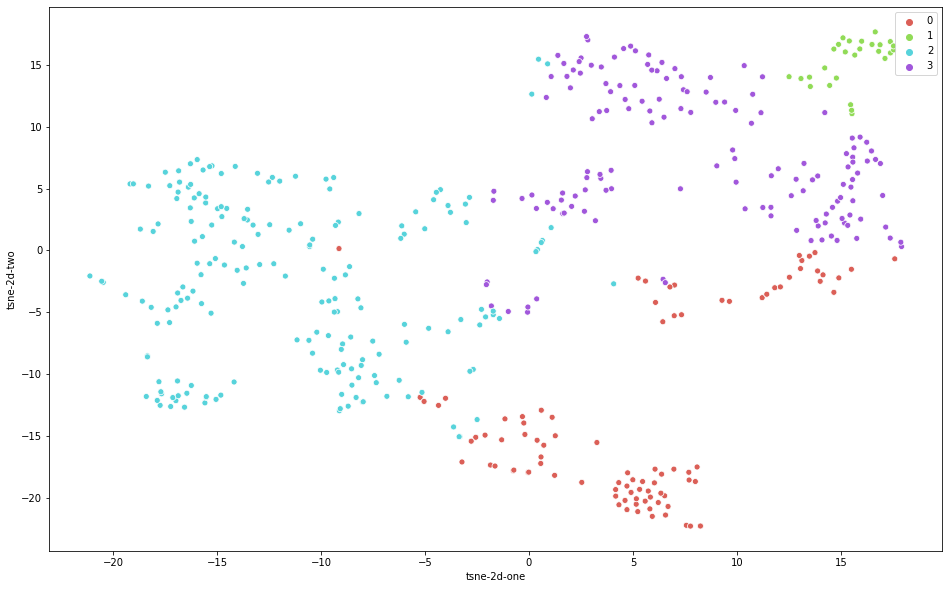

In [5]:
# t-SNE Graph
def tsne(tempData):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(tempData)

    new = tempData.copy()
    new['tsne-2d-one'] = X_2d[:,0]
    new['tsne-2d-two'] = X_2d[:,1]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x = "tsne-2d-one", y = "tsne-2d-two",
        hue = kmeans.labels_,
        palette = sns.color_palette("hls", 4),
        data = new,
        legend = "full"
    )
    
tsne(df)

In [6]:
df[kmeans.labels_ == 1].loc[[42, 240, 373, 432, 438], :].mean(axis=0)

combatShipsLost    0.951251
exploShipsLost     0.027679
miningShipsLost    0.021071
otherShipsLost     0.000000
secStatus         -1.898907
shipsDestroyed     0.081622
soloRatio          0.178000
dtype: float64

**TODO: Write your observations here:**

- In this analysis, the cluster to be discussed is **cluster 1 (green)** and we take players $42, 240, 373, 432$ and $438$ from the original dataset `df`, all of whom are clustered to cluster 1. From the mean average of these 5 players shown in the code cell right above, we can see that these players lost almost only combat ships with the average of $95.1\%$. Furthermore, their security status is deeply negative with average of $-1.9$. Also, the average `soloRatio` among them is pretty high, almost $1.8$. These values indicates with high certainty that they are of **Killer** player type. Therefore, **cluster 1 is the cluster of Killer type**.


- **Q**: *Can you explain the meaning of the distance between the clusters?*
- **A**: Unfortunately, with t-SNE, we cannot tell what the distance between clusters means. The inter-cluster distance shown in a t-SNE plot depends on the perplexity value passed in t-SNE, which is a global parameter and needs to be fine-tuned in accordance with the overall number of data points. For this reason, there may not be one perplexity value that will capture distances across all clusters. Furthermore, t-SNE tries to capture structure in the sense that neighboring data points in the input space will tend to be neighbors in the low dimensional space, but t-SNE does not care how far the distance is. That being said, t-SNE only tries to maintain the intra-cluster distance, not the inter-cluster distance, from higher dimensional space to a lower dimensional space. Therefore, the inter-cluster distance from t-SNE might not mean anything. 

## Task 5.4: Comparing results to other games

Take a look at this clustering, which clusters players from the game *Battlefield 2: Bad Company 2* into seven different categories:

| Name             | % of players | characteristics                                                         |
|------------------|--------------|-------------------------------------------------------------------------|
|snipers           |   7.4        |median spm, overall low-middling values, high dpm, highest accuracy      |
|soldiers          |   27.9       |median spm, overall low-middling values, high dpm                        |
|assault-engineers |   13.1       |similar to soldiers, but higher skill, high k/d ratios                   |
|target dummies    |   26.0       |lowest scores except dpm                                                 |
|trainee veterans  |   10.7       |comparable to veterans, but lower rank and playtime                      |
|assassins         |   10.9       |highest rank in all k/d ratios, highest kpm, low playtime, low dpm       |
|veterans          |   4.1        |high playtime, second rank in most features, highest overall skill level |

Compare this to the clustering we did and discuss the applicability of Radoff's model to games of different genres, based upon these two cluster results.  
**Hint:** To compare it to EVE, first think how (if at all) the 7 categories could be condensed into 4.

**TODO: Write your observations here:**

We can condense these seven categories into 4 categories as follows:
- **Experts**, which composes of ***veterans*** and **trainee veterans** categories. These players have high rankings and playtime.
- **Profesionals**, which composed of ***assassins*** and ***assault-engineers*** players. These players have high skills (regardless their playing style), high k/d ratios.
- **Intermediaries** composes of ***snipers*** and ***soldiers*** players. These players have high dpm (damage/min), median spm and overall low-middling values.
- **Amateurs** comprises only ***target dummies***, who have worst performance in game.

Compared to the clustering results from game EVE Online, we can roughly map these 4 categories to the 4 player types of EVE Online with rather weak arguments as follows:
- **Experts $\Leftrightarrow$ Achievers**: these are users who strike hard for top rankings or for rewards by levelling up and being on top. Thus, they have high playtime to achieve and maintain their goals. Also, they are certainly very skilful players, so their overall scores are among the highest.
- **Professionals $\Leftrightarrow$ Killers**: these are users who have high desire to eleminate enemies, therefore they are typically very skilled in combat. They play to accomplish their need for dominating other people only and achieving high ranks or best performance is not what they seek, therefore, their playtime is rather low, but they have rather high game performance due to their high combat skills. 
- **Intermediaries $\Leftrightarrow$ Socializers**: these players play the game just to satisfy their socialzation/communication need with other players or with friends. In Battlefield, their goal is mostly to collaborate and interact with other players, therefore, winning as a team is more important for them than achieving personal performance scores, so they usually take the supporter role in a team, and as a consequence, their individual performance are usually mediocre.
- **Amateurs $\Leftrightarrow$ Explorers**: these players just aim to explore all the features of the game and/or try to find new experience through the game. Therefore, they play to fulfil their curiosity and does not care about the performance in game, whether they get killed or get shot, it does not matter to them. That's why they have worst performance for the game.

Although these mappings and theirs corresponding arguments may look and sound plausible, it is not hard to find a counter-arguments against them or flaws in them:
- First, Due to the nature of game Battledfield, which is a shooting game, in which a player has only two options: kill or be killed, so we can say that every player can be of Killer type, which is also a valid argument.
- Second, the characteristics such as dpm (Damages/minute), spm (Scores/minute), kpm (Kills/min), k/d ratios (Kills/Deaths ratio) and ranks are measures for game performance of individual player. Therefore, these are **not** good measures to categorize Socializers and Exploreres, since these two types of player do not care much about those numbers.
- Third, The arguments for **Intermediaries $\Leftrightarrow$ Socializers** and **Amateurs $\Leftrightarrow$ Explorers** above may be subjective because Intermediaries and Amateurs may just be players who are not competent enough to have high performance scores.
- Fourth, the boundary between Achievers and Killers seems to be only due to ranking, which is likely highly correlated with playtime. This is not a good indicator to categorize these two types of player. In other words, we cannot say, Achiever are players who play more the game more than Killers.
- Finally, from the overal mappings above, it might be appropriate to say an Amateur is no match for an Expert, but it is not reasonable at all to say an Explorer is no match for an Achiever. In general, it is not a good idea to map ordinal categories (Amateurs, Intermediaries, Professionals and Experts) to nominal ones (Explorers, Socializers, Killers and Achievers).

Based on these counter-arguments, we can see that for a high competative shooter game like Battlefield, it is hard to apply 
the four types of Radoff's model precisely. Due to the nature of shooter games, the separation line between Achievers and Killers is pretty much obscure. Moreover, every player, once they have decided to play such games, is more or less of a Killer type, who wants to beat/kill other people to see them lose or die. Therefore, most players display some traits in more than one category. In the other hand, for massively multiplayer online role-playing games like EVE Online, four player types of Radoff's model are more obvious to observe. This might be because role-playing games have broader and more game contexts than shooter games. In role-playing games, combating and destroying one another are not neccessarily the only achievable game outcome, while winning/losing is the only outcome of shooter games. 

In conclusion, for game genres characterized by acting upon other players and/or the game world with high competitiveness to achieve game outcomes, Radoff's model of player types may only be appropriate to cluster only Killers and Achievers, since those games typically categorize players by an ordinal scale based on in-game performance and they normally have limited features for players to interact with other players or the game world. For this reason, Socializers and Explorers generally do not prefer playing those games. In general, it is not a good idea to apply Radoff's model to games that categorize users by ordinal scale of game performance, instead of acting and interacting with other players and game world. Therefore, Radoff's model of player types should be applied flexibly and carefully to different game genres. 

<!--     - Additionally, for **Amateurs $\Leftrightarrow$ Explorers**, one can also argue that Battlefield is a first-person shooter game with high competitiveness. So, players won't have much space and time to explore features in game    -->